<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab2_Capacitors/blob/main/Lab2_Capacitor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2. Capacitor experiment
Moodle: https://moodle2222.technion.ac.il/mod/resource/view.php?id=1119329

[.pdf manual](https://moodle2222.technion.ac.il/pluginfile.php/1816957/mod_resource/content/2/%D7%AA%D7%93%D7%A8%D7%99%D7%9A%20%D7%A7%D7%91%D7%9C%20%D7%90%D7%91%D7%99%D7%91%202022.pdf)

Evgeny Kolonsky, Feb 2023
Update Apr 2023

## Setup
1. Capacitor experiment kit:
  - Aluminium disks 260mm x2 on plate, dielectric sheet
  - Aluminium disks 180mm x2 on plate, dielectric sheet
  - dock board
  - banana wires short-length, x2
2. Wires:
  - coaxial-banana, x1 
  - coaxial, x3  
3. Measurement equipment:
  - Scope Keysight
  - LCR 
  - Caliper


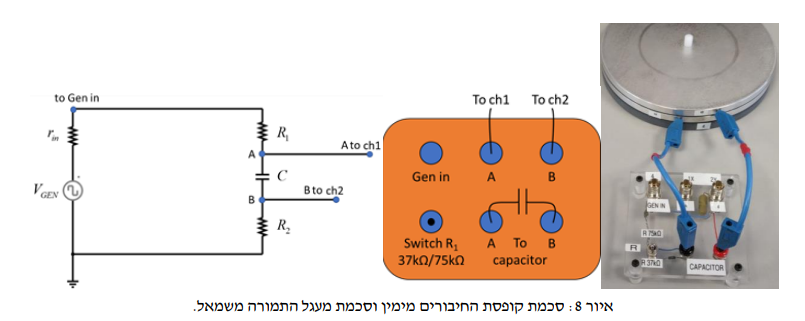

In [2]:
!pip install quantiphy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.2 MB/s eta 0:00:00


In [3]:
import numpy as np # math functions
import scipy # scientific functions
import matplotlib.pyplot as plt # for plotting figures and setting their properties
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import pandas as pd # handling data structures (loaded from files)
from scipy.stats import linregress # contains linregress (for linear regression)
from scipy.optimize import curve_fit as cfit # non-linear curve fitting
from sklearn.metrics import r2_score # import function that calculates R^2 score
import json, requests
import pandas as pd

from quantiphy import Quantity



In [4]:
def q_Farad(x):
  return str(Quantity(x,'F'))

## C12

Measure Resistance

### 1. Build the plate capacitor with the largest possible capacitance in the system, without using the dielectric material.
Calculate its capacitance from the formula.

$$ C = {A \varepsilon_0 \varepsilon_r \over d}$$ 

Make square impuls: freq 500Hz, Vpp =5V, Offset = 2.5V. Catch discharge on the scope using Trigger - WaveGen. Acquire Averaged signal.


### 4. Method A. Direct capacitance $C$ measurement

### 4. Method B. Capacitance $C$ calculation

$$Q = C V$$

$$ Q = \int_0^t I(t) dt$$

### 6. Decay time $\tau$ calculation

$$ \tau = R C$$



Stripping non-linear right part of data, where $t>0.00115 s$.

## 10. Small disks with dielectric

We do not know $\varepsilon_r$, so we have to calculate it later using capacitance measurements.

# Reproduce calcs with github-stored data

### Class definitions, bla-bla-bla

In [31]:
class Board:
  url = ''
  num = ''
  option = ''
  R_in = 50 # Ohm
  R1 = 0
  R2 = 0
  R = 0

  def __init__(self, num, option='1', url='https://raw.githubusercontent.com/evgeny-kolonsky/Lab2_Capacitors/main/'):
    self.url = url + 'Boards.csv'
    self.num = num
    self.option = option
    df = pd.read_csv(self.url)
    row = df[(df.Set == self.num) & (df.Option == option)]
    self.R1 = row.R1.tolist()[0]
    self.R2 = row.R2.tolist()[0]
    self.R = self.R_in + self.R1 + self.R2

class Capacitor:
  url = ''
  num = ''
  size = 0
  side = ''
  square = 0
  d = np.array([0,0,0])
  C_calculated = 0
  C_measured = 0

  def __init__(self, num, size=260, side='A', url='https://raw.githubusercontent.com/evgeny-kolonsky/Lab2_Capacitors/main/'):
    eps0 = scipy.constants.epsilon_0
    self.num = num
    self.size = size
    self.side = side
    diam = float(self.size) *1e-3 # mm->m
    self.square = np.pi*diam*diam/4
    self.url = url + 'Disks.csv'
    df = pd.read_csv(self.url)
    row = df[(df.Set == num) & (df.Diam==size) & (df.Side==side)]
    d1, d2, d3 = row.d1.tolist()[0], row.d2.tolist()[0], row.d3.tolist()[0]
    self.d = np.array([d1, d2, d3]) *1e-3 # mm -> m
    self.C_calculated = self.square/np.mean(self.d) * eps0
    self.C_measured = row.C_measured.tolist()[0] *1e-12 ## pF -> F 

class Experiment:
  num = ''
  trace_num = 0
  fname = ''
  url = ''
  board = ''
  capacitor = ''
  data = ''
  Vx = ''
  Vy = ''
  time = ''
  Q = ''
  I = ''
  C_Q = 0
  C_tau = 0
  filter = ''

  def reset_filter(self):
    self.filter = np.full(self.time.shape, True)
    return

  def cut_Vx(self, low, high):
    self.filter = self.filter * (self.Vx > low) * (self.Vx < high)
    return

  def cut_t(self, low, high):
    self.filter = self.filter * (self.time < high) * (self.time > low)
    return

  def __init__(self, num, trace_num=0,
               url='https://raw.githubusercontent.com/evgeny-kolonsky/Lab2_Capacitors/main/'):
    self.num = num
    self.trace_num = trace_num
    print('Read from Experiments table..')
    self.url = url + 'Experiments.csv'
    df = pd.read_csv(self.url)
    row = df[(df.Set == num) & (df.Trace==trace_num)]
    self.size = row.Size.tolist()[0]
    self.side = row.Side.tolist()[0]
    self.option = row.Option.tolist()[0]
    print(f'Set {num}, Trace {trace_num}, Size {self.size} Side {self.side} Option {self.option}')
    print(f'Read from Board table: Set {num}, {self.option}')
    self.board = Board(num, self.option, url)
    print(f'R1 = {self.board.R1}')
    print(f'Read from Disks table: Set {num}, {self.size} {self.side}')
    self.capacitor = Capacitor(num, self.size, self.side, url)
    print(f'Capacitance measured {q_Farad(self.capacitor.C_measured)}')
    self.fname = f'{url}{num}/Trace%20{trace_num}.csv'
    self.data  = pd.read_csv(self.fname, header=1)
    columns = 'Time (s),1 (VOLT),2 (VOLT)'.split(sep=',')
    self.time = np.array(self.data[columns[0]])
    self.Vx = np.array(self.data[columns[1]])
    self.Vy = np.array(self.data[columns[2]])
    self.reset_filter()
    return

  
  def get_filtered_data(self):
    vx = self.Vx[self.filter]
    vy = self.Vy[self.filter]
    t  = self.time[self.filter]
    return t, vx, vy


  def Calculate_Q(self, show=True):
    # Q - method
    t, vx, vy = self.get_filtered_data()
    V_c = vx - vy
    I_c = vy / self.board.R2
    Q_c = scipy.integrate.cumtrapz(I_c, x=t, initial=0)
    self.Q = Q_c
    fit = linregress(V_c, Q_c)
    self.C_Q = fit.slope
    if show:
      s = str(Quantity(self.C_Q, 'F'))
      plt.plot(V_c, Q_c, label='$Q=\\int I dt$')
      plt.plot(V_c,fit.slope*V_c + fit.intercept, label=f'Q-method $C={s}$')
      plt.grid()
      plt.legend()
      plt.xlabel('Voltage, [V]')
      plt.ylabel('Charge, [C]')
      plt.title('$Q = C V$')
    return

  def Calculate_tau(self, show=True):
    t, vx, vy = self.get_filtered_data()
    V_c = vx - vy
    fit = linregress(t, np.log(V_c))
    beta = fit.slope
    tau_fit = -1/beta
    self.C_tau = tau_fit/self.board.R
    if show:
      plt.plot(t, np.log(V_c), label='Measurements')
      s = Quantity(self.C_tau, 'F')
      plt.plot(t, t*beta + fit.intercept, label=f'Tau-method $C$={s}')
      plt.setp(plt.gca().get_xticklabels(), rotation=45, ha='right')
      plt.grid()
      plt.legend()
      plt.ylabel('Log Voltage, [V]')
      plt.xlabel('Time, [s]')
      plt.title('$\log V = t/\\tau, \\tau = RC$')

    return

  def plot_V(self):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.set_xlabel('Time, [s]')
    ax1.set_ylabel('$V_x$, [V]')
    ax2.set_ylabel('$V_y$, [V]')

    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    t, vx, vy = self.get_filtered_data()

    ax1.plot(t, vx, color='yellow', marker='.', label='$V_a$')
    ax2.plot(t, vy, color='green', label='$V_b$')

    plt.grid()
    ax1.legend()
    ax2.legend()
    plt.show()
    return

  def print(self):
    print(f'Experiment parameters: Set {self.num}, trace {self.trace_num}, Size {self.size}, Side {self.side}, {self.option}')
    print('Calculated    :'+ q_Farad(ex.capacitor.C_calculated))
    print('Direct measure:'+ q_Farad(ex.capacitor.C_measured))
    print('Measure by Q  :'+ q_Farad(ex.C_Q))
    print('Measure by tau:'+ q_Farad(ex.C_tau))    




### Now we can get, plot and play with experimental data saved on github.

Read from Experiments table..
Set C01, Trace 0, Size 260 Side A Option R37
Read from Board table: Set C01, R37
R1 = 37600.0
Read from Disks table: Set C01, 260 A
Capacitance measured 427 pF


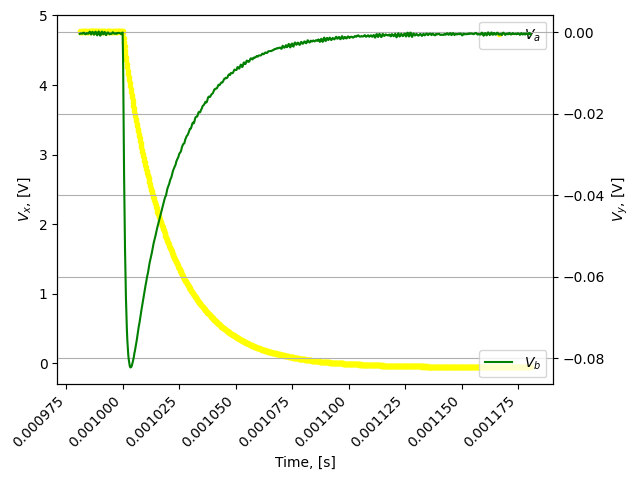

In [32]:
ex = Experiment('C01', trace_num=0)
ex.plot_V()

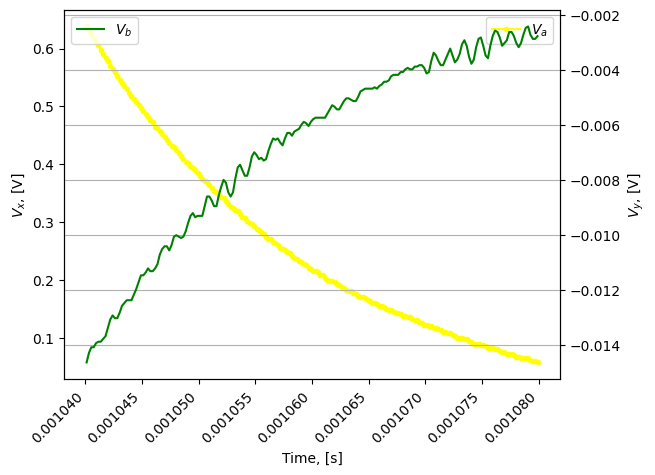

In [33]:
ex.reset_filter()
ex.cut_t(0.00104, 0.00108)
ex.cut_Vx(0, 0.7)
ex.plot_V()

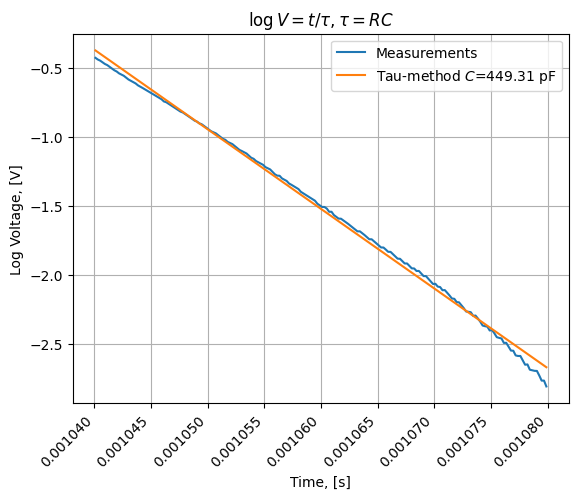

In [34]:
ex.Calculate_tau()

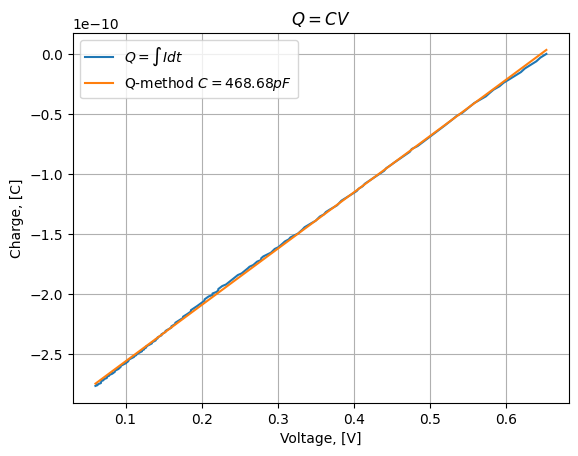

In [35]:
ex.Calculate_Q()

In [10]:
ex.print()

Experiment parameters: Set C01, trace 0, Size 260, Side A, R37
Calculated    :428.66 pF
Direct measure:427 pF
Measure by Q  :468.68 pF
Measure by tau:449.31 pF


Read from Experiments table..
Set C01, Trace 1, Size 260 Side B Option R37
Read from Board table: Set C01, R37
R1 = 37600.0
Read from Disks table: Set C01, 260 B
Capacitance measured 586 pF


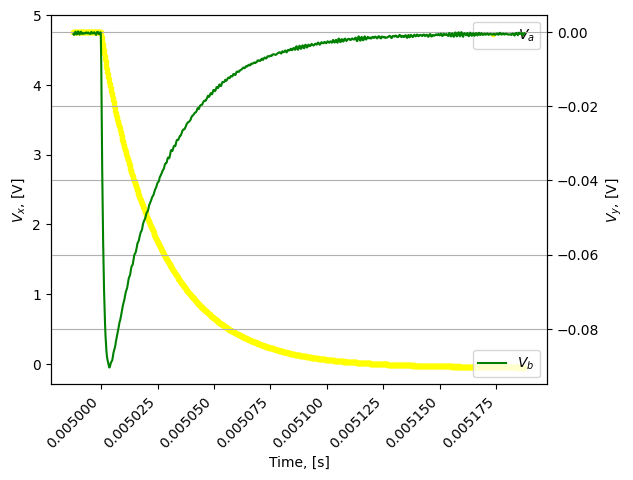

In [36]:
ex = Experiment('C01', trace_num=1)
ex.plot_V()

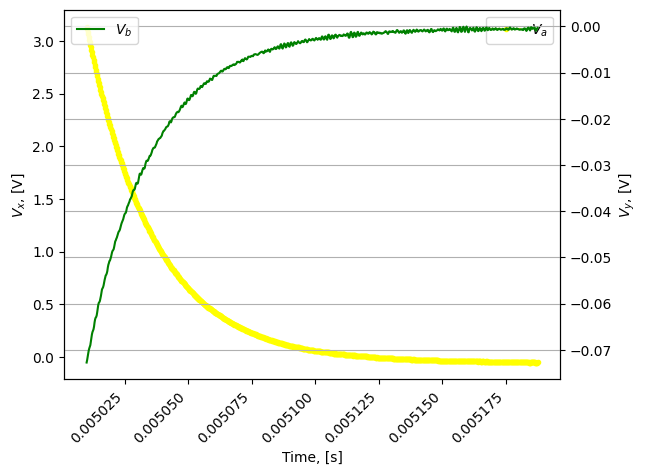

In [37]:
ex.reset_filter()
ex.cut_t(0.00501, 1)
ex.plot_V()

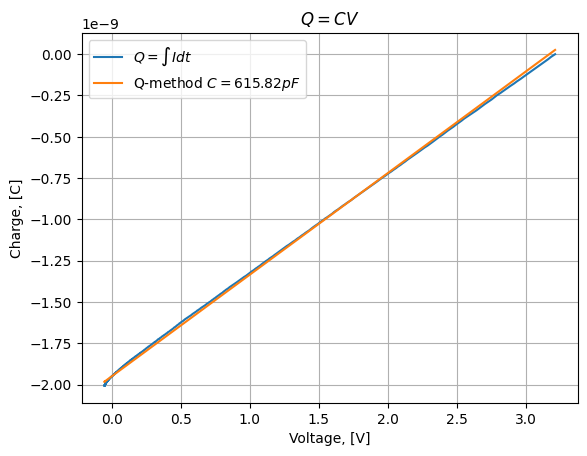

In [38]:
ex.Calculate_Q()

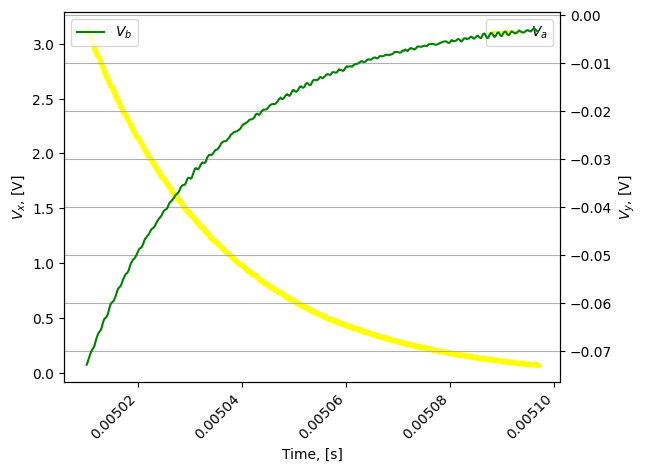

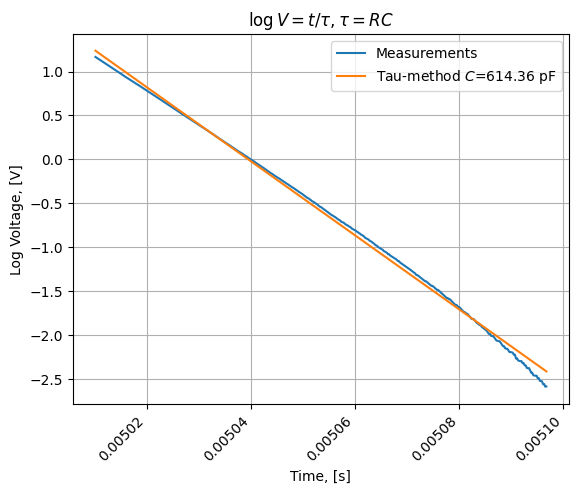

In [39]:
ex.cut_Vx(0.07, 5)
ex.plot_V()
ex.Calculate_tau()

In [40]:
ex.print()

Experiment parameters: Set C01, trace 1, Size 260, Side B, R37
Calculated    :592.56 pF
Direct measure:586 pF
Measure by Q  :615.82 pF
Measure by tau:614.36 pF
